# Example Sheet 1

## Pre-Amble

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, HuberRegressor, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import scipy as sp
from statsmodels.api import OLS

plt.style.use("/home/jhughes2712/projects/coursework/mphildis-coursework/mphil.mplstyle")

## Question 1

### Question 1.a.

Summaries for continuous variables can be split into measures of location and spread. Measures of location include:
- mean;
- median;
- mode.

Measures of spread include:
- variance;
- standard deviation;
- median absolute deviation (MAD);
- range;
- interquartile range.

It is worth noting that the mean and variance/stdev are influenced more heavily by outliers, and in this case may not represent the true distribution well. The median and MAD are alternatives which are more robust. Moreover, significant discrepancies in, say, the mean and median may indicate the presence of outliers in the data (for instance a mean significantly greater than the median could suggest the presence of high-valued outliers.)

But these alone provide little information about the shape/type of the distribution itself. This can be highlighted more by quantiles - the value below which a certain proportion of the data lies. In particular we may be interested in:
- min and max;
- upper and lower quartiles;
- deciles;
- percentiles.

Using finer quantiles such as those at 10% or 1% granularity is much more informative in terms of describing the type of distribution, but is less intuitive. Other less common measures of the shape of the distribution are the skew (roughly relating to the symmetry of the tails) and the kurtosis (indicating the width of the modal peak of the distribution with respect to the length of the tails).

For categorical variables, we can compute the modal category, as well as the number of categories in total. In terms of ensuring informative features, we mainly wish to verify that there is variation, and for that we can compute:
- frequency ratio, the ratio of the frequencies of the two most prevalent values;
- percentage of unique values, the count of unique values as a percentage of the total count of datapoints.

For categorical data to be informative it is best to have a low frequency ratio (the minimum and best case being 1.0) and a high percentage of unique values (although we don't want this so high that there are only one or two instances of each category in the data!) In the extreme, we either have one category comprising most of the data, or almost every datapoint has a different category, and in both cases the feature is not informative because it is near constant (in the second case, consider that each of the one-hot encoding variables will be near constant), so the ideal is somewhere in the middle.

### Question 1.b.

For Questions 1.b., 1.c. I created a "Polar Bear" dataset inspired by the penguins data used in class, with the code below.

In [2]:
"""sexes = ["Male", "Female"]
islands = ["Glacial", "Galapagos", "Svalbard"]

df = pd.DataFrame()
df["sex"] = random.sample(sexes, counts = [500, 500], k=100)
df["island"] = random.sample(islands, counts = [300, 400, 300], k=100)
df["children"] = np.concatenate([np.random.poisson(2, 80), np.random.poisson(3, 20)])*(df["sex"]=="Female") + (df["island"]=="Glacial")
df["height"] = np.concatenate([np.random.normal(2, 0.2, 70), np.random.normal(1.6, 0.1, 30)]) + np.random.normal(0.8,0.4)*df["children"]
df["weight"] = 30*np.random.beta(7,3,100)*df["height"] + np.random.normal(10,5,100)

df.to_csv("polar_bears.csv", index=False)"""

'sexes = ["Male", "Female"]\nislands = ["Glacial", "Galapagos", "Svalbard"]\n\ndf = pd.DataFrame()\ndf["sex"] = random.sample(sexes, counts = [500, 500], k=100)\ndf["island"] = random.sample(islands, counts = [300, 400, 300], k=100)\ndf["children"] = np.concatenate([np.random.poisson(2, 80), np.random.poisson(3, 20)])*(df["sex"]=="Female") + (df["island"]=="Glacial")\ndf["height"] = np.concatenate([np.random.normal(2, 0.2, 70), np.random.normal(1.6, 0.1, 30)]) + np.random.normal(0.8,0.4)*df["children"]\ndf["weight"] = 30*np.random.beta(7,3,100)*df["height"] + np.random.normal(10,5,100)\n\ndf.to_csv("polar_bears.csv", index=False)'

For continuous data it is best to use a visualisation technique in the first instance to identify outliers. 

In [3]:
polar_df = pd.read_csv("polar_bears.csv")
polar_df.head(5)

,sex,island,children,height,weight
0,Male,Galapagos,0,1.737985,47.191237
1,Female,Galapagos,1,3.109141,85.695837
2,Female,Glacial,2,3.292070,72.941596
3,Male,Galapagos,0,1.763054,24.101194
4,Female,Glacial,3,4.039510,97.567590


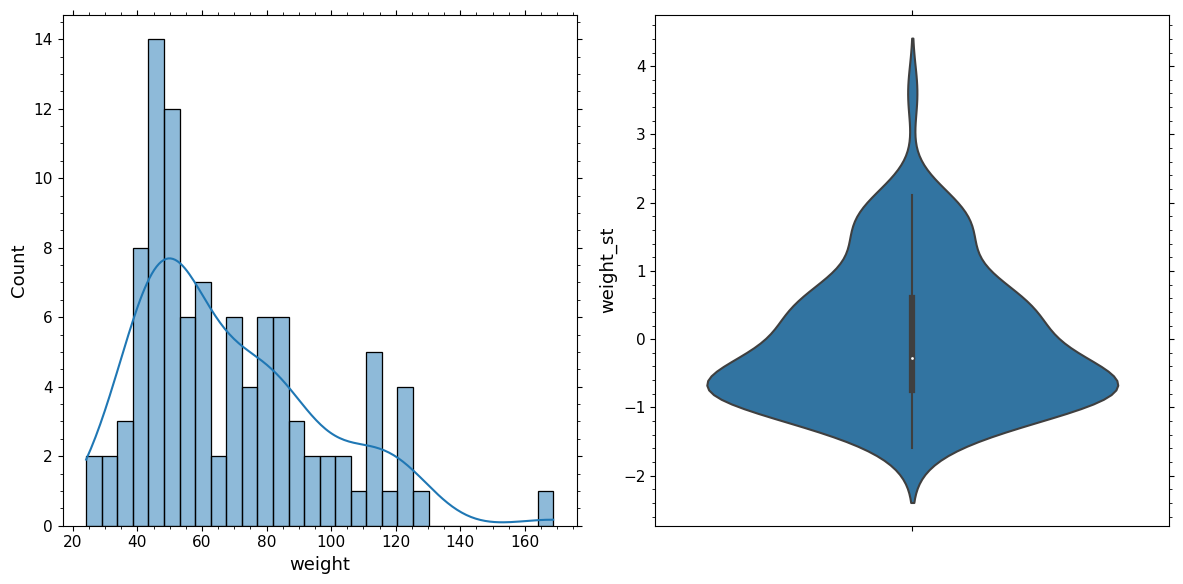

In [4]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
_ = sns.histplot(polar_df["weight"], kde=True, bins=30)
plt.subplot(1,2,2)
standardiser = StandardScaler()
polar_df["weight_st"] = standardiser.fit_transform(polar_df[["weight"]])
_ = sns.violinplot(polar_df, y="weight_st")
plt.show()

The above is an example of how we can use a mixture of visualisation and standardisation to spot outlier data. In this case, we have used a Z-transform of the form
$$ Z = \frac{X-\mu}{\sigma} $$
where $\mu$ is the mean and $\sigma$ is the standard deviation of the sample.

There is an outlier datapoint with a weight of about 165 identified in the histogram, which is then further evidenced by its Z score of +4 (standard deviations) in the standardisation process.

Frequency Ratio is: 1.3125.
Percentage Unique Values is: 3.00%.


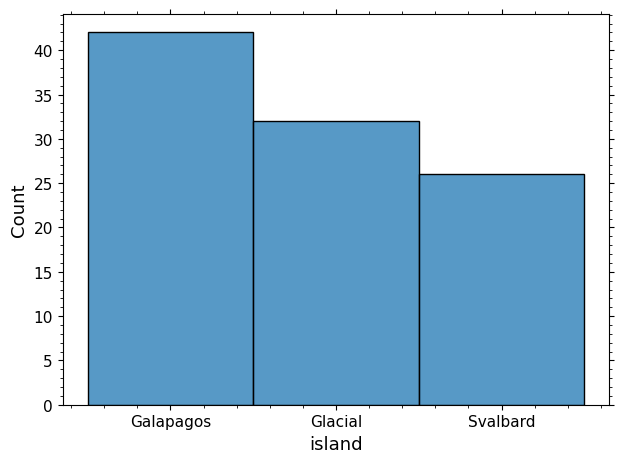

In [5]:
_ = sns.histplot(polar_df["island"])
island_counts = polar_df["island"].value_counts().sort_values(ascending=False)
freq_ratio = island_counts.iloc[0] / island_counts.iloc[1]
pct_unique = len(island_counts) / len(polar_df["island"])
print("Frequency Ratio is: {}.\nPercentage Unique Values is: {:.2f}%.".format(freq_ratio, pct_unique*100))

The above leads us to believe that there are no outliers with respect to the island variable, since each of the three categories has at least 25 instances throughout the dataset. Moreover, the feature is informative since it has a low frequency ratio of about 1.3, which means that there is not one category that dominates the feature.

### Question 1.c.

In [6]:
missing_indices = np.random.choice(100, 40, replace=False)
polar_df_missing = polar_df.copy()
polar_df_missing.loc[missing_indices, "height"] = np.nan

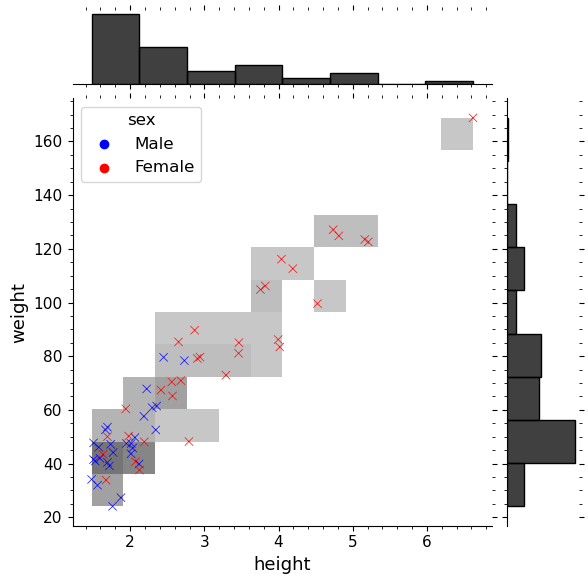

In [7]:
jp = sns.jointplot(polar_df_missing, x="height", y="weight", kind="hist", color="black", bins=12, alpha=0.8)
_ = sns.scatterplot(polar_df_missing, x="height", y="weight", hue="sex", ax = jp.ax_joint, palette=["blue","red"], marker="x")

In [8]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer_knn = KNNImputer(n_neighbors=5)

polar_df_missing["height_imp_mean"] = imputer_mean.fit_transform(polar_df_missing[["height"]])
polar_df_missing["height_imp_knn"] = imputer_knn.fit_transform(polar_df_missing[["height", "weight"]])[:,0]

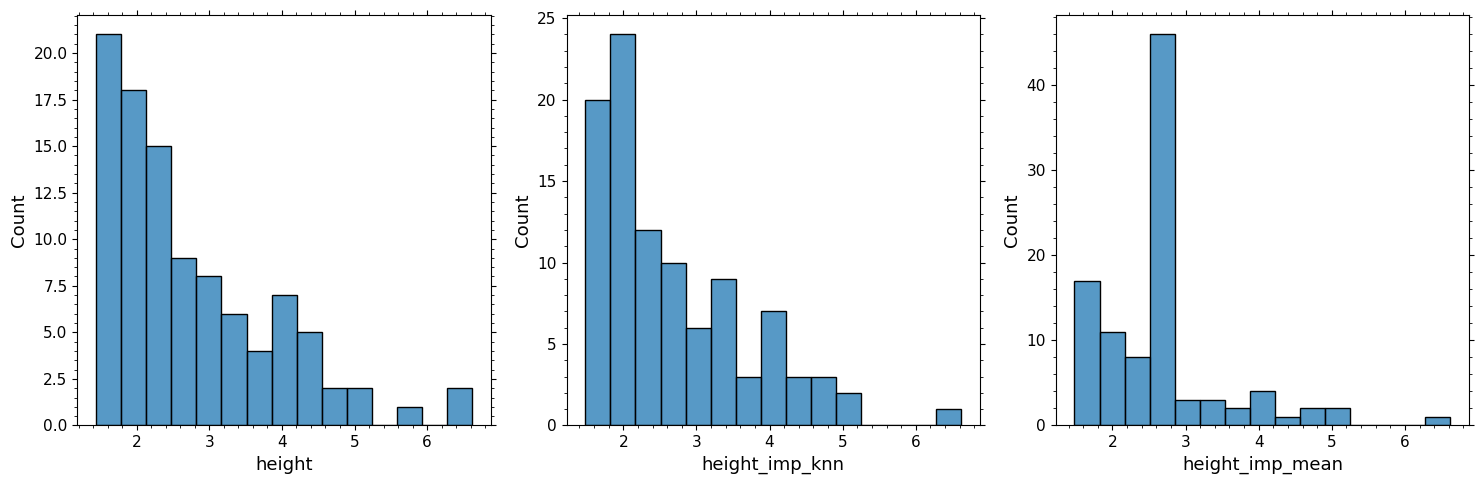

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
_ = sns.histplot(x=polar_df["height"], bins=15)
plt.subplot(1,3,2)
_ = sns.histplot(x=polar_df_missing["height_imp_knn"], bins=15)
plt.subplot(1,3,3)
_ = sns.histplot(x=polar_df_missing["height_imp_mean"], bins=15)
plt.show()

As we can see the model-based imputation was much more successful. We could improve the mean-based imputation by considering the structure of the data; for instance we could impute the mean according to the sex of the polar bear.

## Question 2

In [10]:
preprc_df = pd.read_csv("PreProcessing_ex2.csv")
preprc_df.head(5)

,feature_1,feature_2,feature_3
0,63.709584,117.414523,Red
1,44.353018,90.374923,Red
2,53.631284,113.119194,Blue
3,56.328626,122.954948,Yellow
4,100.000000,250.000000,Yellow


In [11]:
preprc_df.describe()

,feature_1,feature_2
count,200.000000,200.000000
mean,50.004500,100.334766
std,11.951209,25.207456
min,3.000000,0.000000
25%,43.797476,87.271306
50%,49.727313,98.673782
75%,56.336346,113.618801
max,120.000000,250.000000


Frequency Ratio is: 1.5714285714285714.
Percentage Unique Values is: 1.50%.


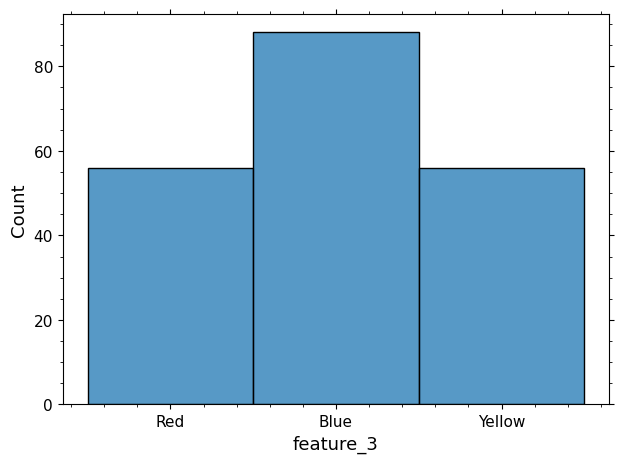

In [12]:
_ = sns.histplot(preprc_df["feature_3"])
colour_counts = preprc_df["feature_3"].value_counts().sort_values(ascending=False)
freq_ratio = colour_counts.iloc[0] / colour_counts.iloc[1]
pct_unique = len(colour_counts) / len(preprc_df["feature_3"])
print("Frequency Ratio is: {}.\nPercentage Unique Values is: {:.2f}%.".format(freq_ratio, pct_unique*100))

The summary statistics for the continuous variables indicate that the data has fairly nice properties; for instance, the symmetry and proximity of the upper and lower quartiles about the median indicates a lack of skewness and likely a unimodal distribution, which could approxiamte a normal distribution. However we already get hints of outliers in the data with the minima and maxima located many standard devations away from the mean.

Again there is sufficient variation in feature_3, which has a fairly low frequency ratio, for it to be an informative feature, and there are no outliers in this case since all three categories are sufficiently represented.

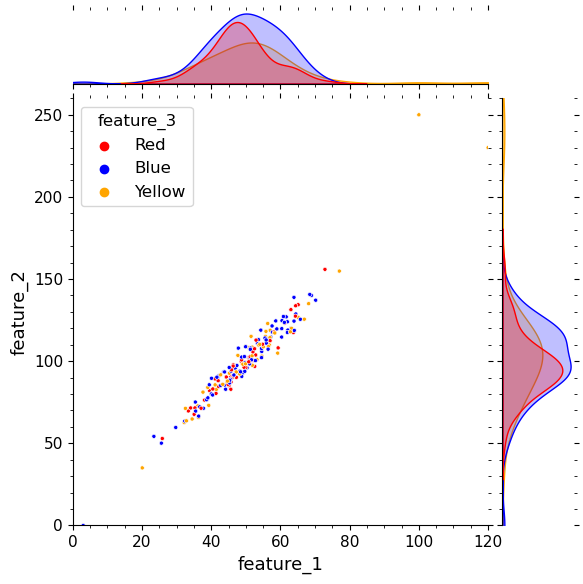

In [13]:
_ = sns.jointplot(preprc_df, x="feature_1", y="feature_2", hue="feature_3", palette=["red", "blue", "orange"], marker =".", xlim=(0,120), ylim=(0,260))

In [14]:
X = preprc_df[["feature_1", "feature_2"]]
standardiser = StandardScaler()
Z = standardiser.fit_transform(X)
preprc_df[["feature_1_st", "feature_2_st"]] = Z

<Figure size 1000x1000 with 0 Axes>

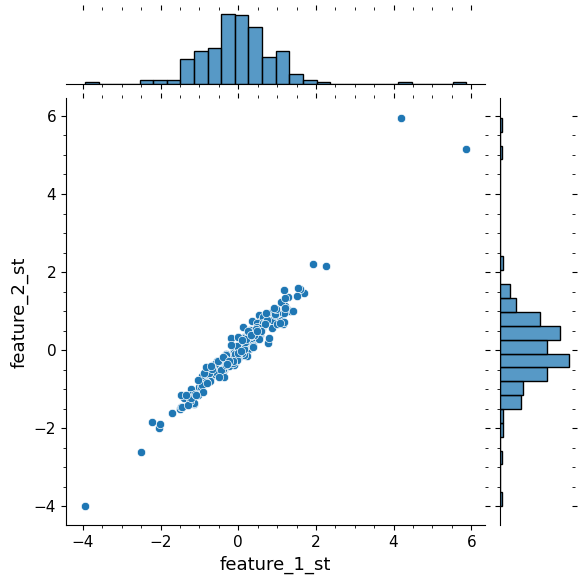

In [15]:
plt.figure(figsize=(10,10))
_ = sns.jointplot(preprc_df, x="feature_1_st", y="feature_2_st")
plt.show()

We can see here through the Z-transformation of the two features that there are potentially 3 outliers in the data, which is evidenced in all 3 cases by both of their continuous features having Z-scores well outside of the $(-3\sigma,+3\sigma)$ range.

## Question 3

In [16]:
g = np.random.default_rng(seed=42)
x_vals = np.arange(1, 101)
X = np.vstack([x_vals**i for i in range(11)]).T
f = lambda z: 0.001*(z**3) - 0.16*(z**2) + 7*z
y = f(x_vals) + g.normal(0, 20, 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.9)

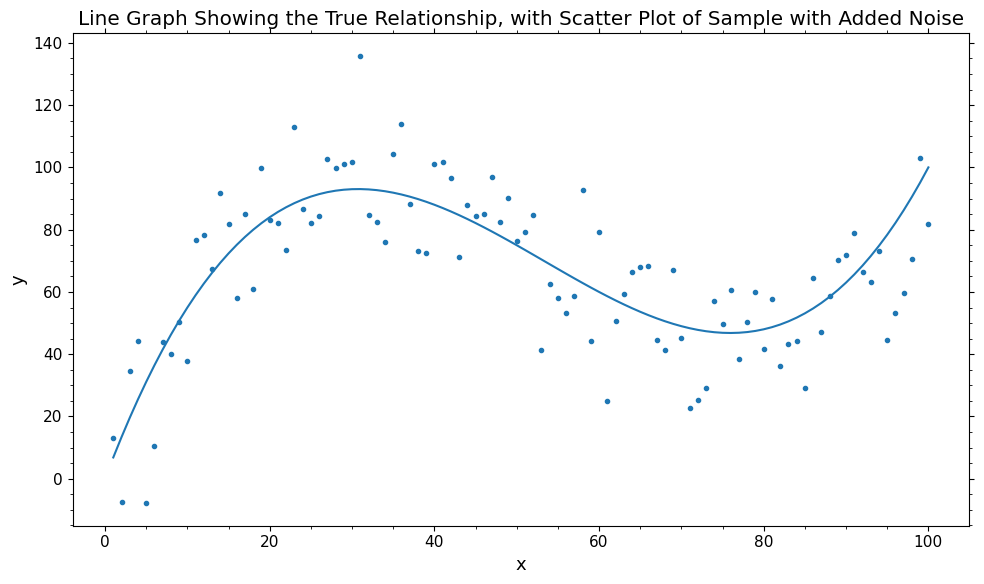

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(x_vals, y, marker='.')
plt.plot(x_vals, f(x_vals))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Line Graph Showing the True Relationship, with Scatter Plot of Sample with Added Noise")
plt.show()

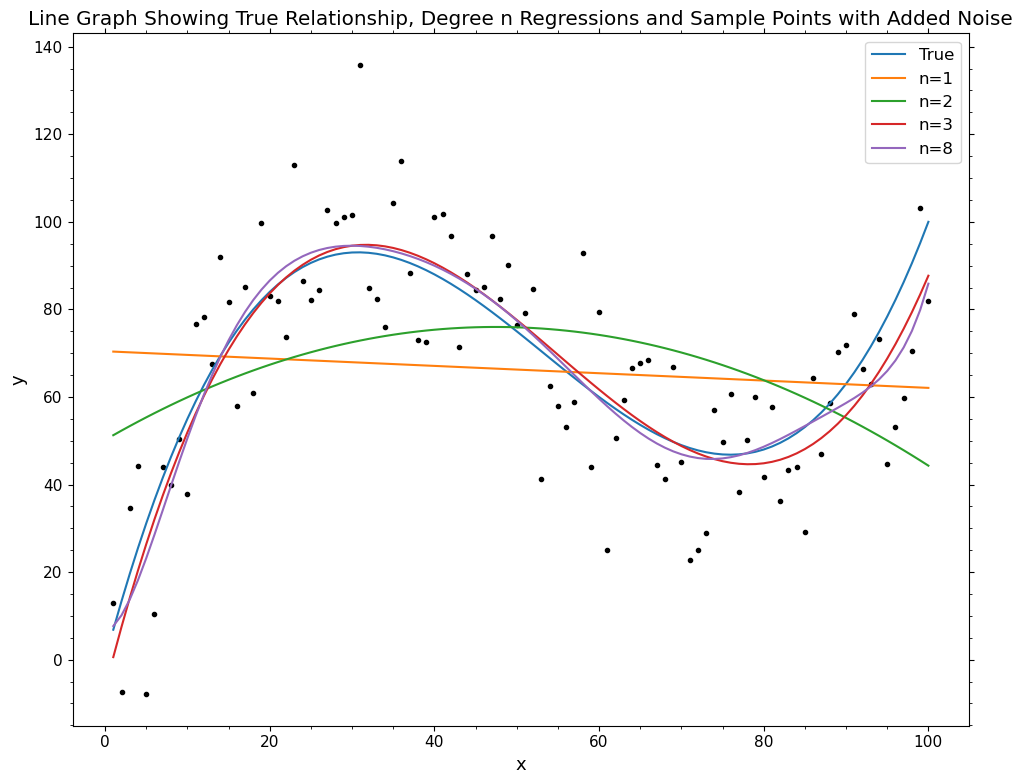

In [18]:
models = {}
for n in range(1,11):
    models[n] = LinearRegression().fit(X_train[:,:n+1], y_train)

plt.figure(figsize=(10,8))
plt.scatter(x_vals, y, marker=".", c="black")
plt.plot(x_vals, f(x_vals), label="True")
plt.plot(x_vals, models[1].predict(X[:,:2]), label="n=1")
plt.plot(x_vals, models[2].predict(X[:,:3]), label="n=2")
plt.plot(x_vals, models[3].predict(X[:,:4]), label="n=3")
plt.plot(x_vals, models[8].predict(X[:,:9]), label="n=8")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Line Graph Showing True Relationship, Degree n Regressions and Sample Points with Added Noise")
plt.show()

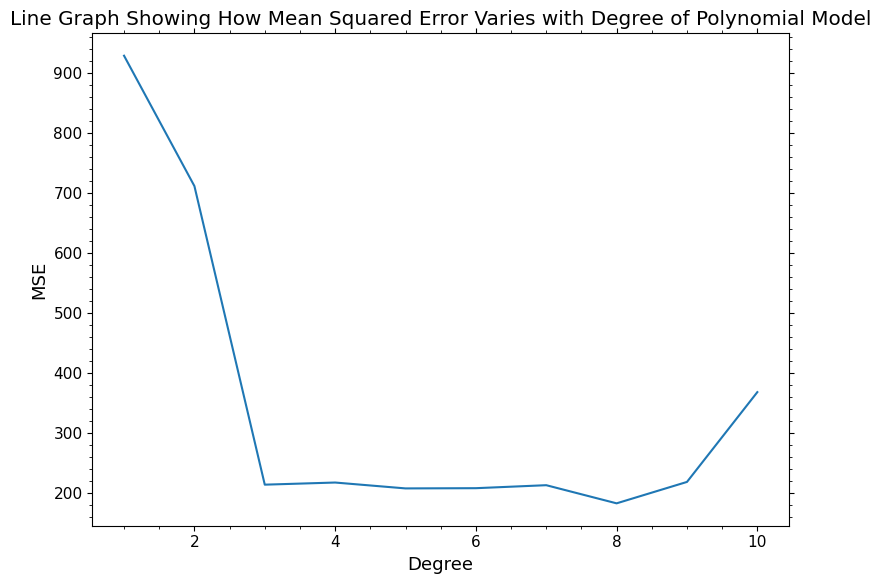

In [19]:
plt.figure(figsize=(8,6))
plt.plot(range(1,11), [mean_squared_error(models[n].predict(X_test[:,:n+1]), y_test) for n in range(1,11)])
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.title("Line Graph Showing How Mean Squared Error Varies with Degree of Polynomial Model")
plt.show()

In [20]:
cv_degree_mse_dict = {}
for n in range(1,11):
    model = LinearRegression()
    cv_degree_mse_dict[n] = cross_val_score(model, X[:,:n+1], y, cv=10, scoring=make_scorer(mean_squared_error))
cv_degree_mse_df = pd.DataFrame(cv_degree_mse_dict)

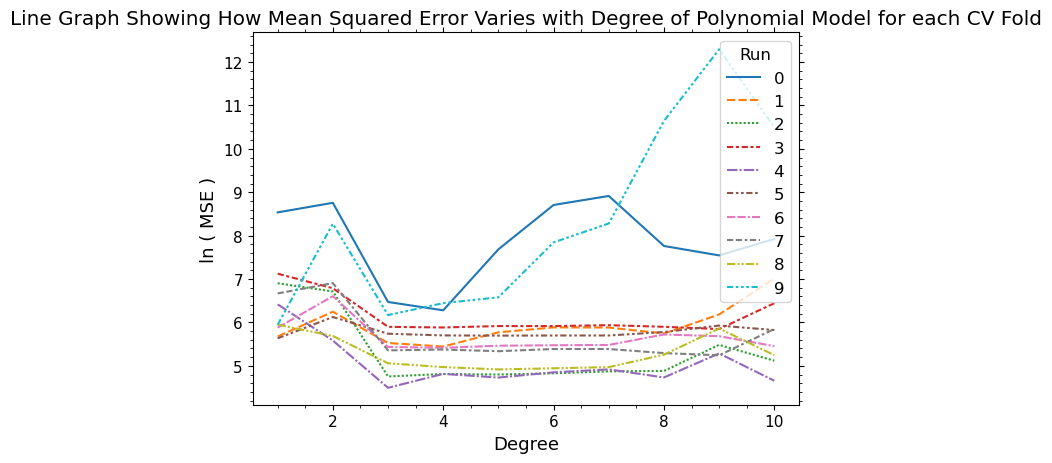

In [21]:
lp_cv_mse = sns.lineplot(np.log(cv_degree_mse_df).T)
plt.title("Line Graph Showing How Mean Squared Error Varies with Degree of Polynomial Model for each CV Fold")
plt.legend(title="Run")
plt.ylabel("ln ( MSE )")
plt.xlabel("Degree")
plt.show(lp_cv_mse)

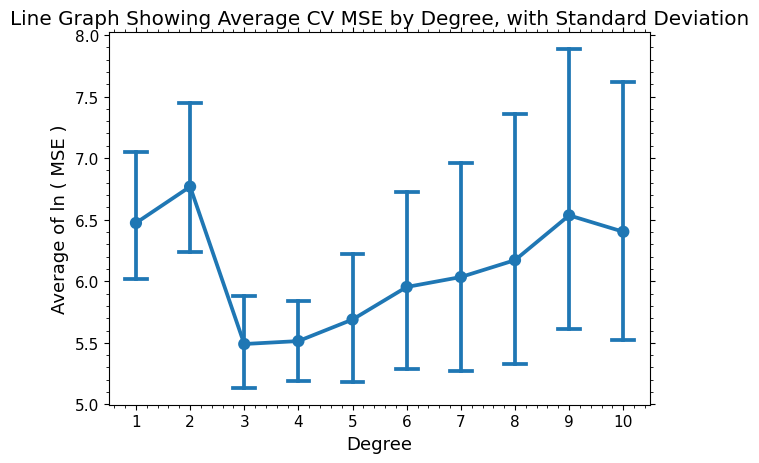

In [22]:
plt.title("Line Graph Showing Average CV MSE by Degree, with Standard Deviation")
lp_cv_mse = sns.pointplot(np.log(cv_degree_mse_df), capsize=0.4)
plt.ylabel("Average of ln ( MSE )")
plt.xlabel("Degree")
plt.show()

## Question 4

### Question 4.i.

In [23]:
regression_df = pd.read_csv("regression_input.csv")
display(regression_df)

,y,pred1,pred2,pred3,pred4
0,0,0,1,0.00,-5
1,10,1,-3,1.58,48
2,20,6,5,1.82,194
3,30,15,15,1.97,443
4,40,18,22,2.09,798
5,50,24,27,2.18,1246
6,60,26,28,2.26,1799
7,70,33,35,2.33,2446
8,80,37,30,2.40,3196
9,90,42,38,2.45,4048


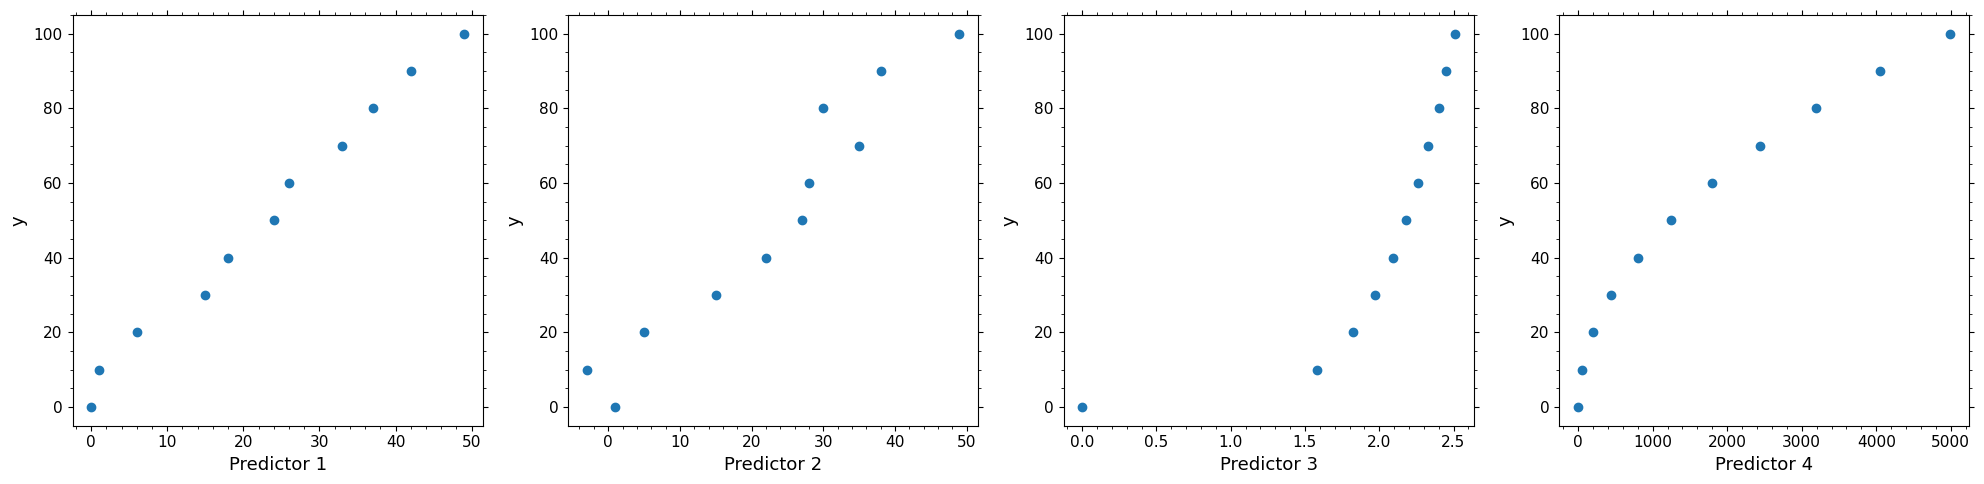

In [24]:
plt.figure(figsize=(20,5))
for p_idx in range(1,5):
    plt.subplot(1,4,p_idx)
    plt.scatter(regression_df["pred"+str(p_idx)], regression_df["y"])
    plt.xlabel("Predictor "+str(p_idx))
    plt.ylabel("y")
plt.show()

All predictors are positively correlated with the output variable $y$. In particular, predictors 1 and 2 could reasonably be considered as having a linear relationship to $y$, whereas predictors 3 and 4 appear to have non-linear relationships with $y$, potentially of the form $y=x^q$ for some $q\in (0,\infty)$.

### Question 4.ii.

Predictor 1: b0 = 4.42, b1 = 2.00, r2 = 0.99141.
Predictor 2: b0 = 6.02, b1 = 1.96, r2 = 0.93470.
Predictor 3: b0 = -22.75, b1 = 37.07, r2 = 0.62880.
Predictor 4: b0 = 17.61, b1 = 0.02, r2 = 0.92777.


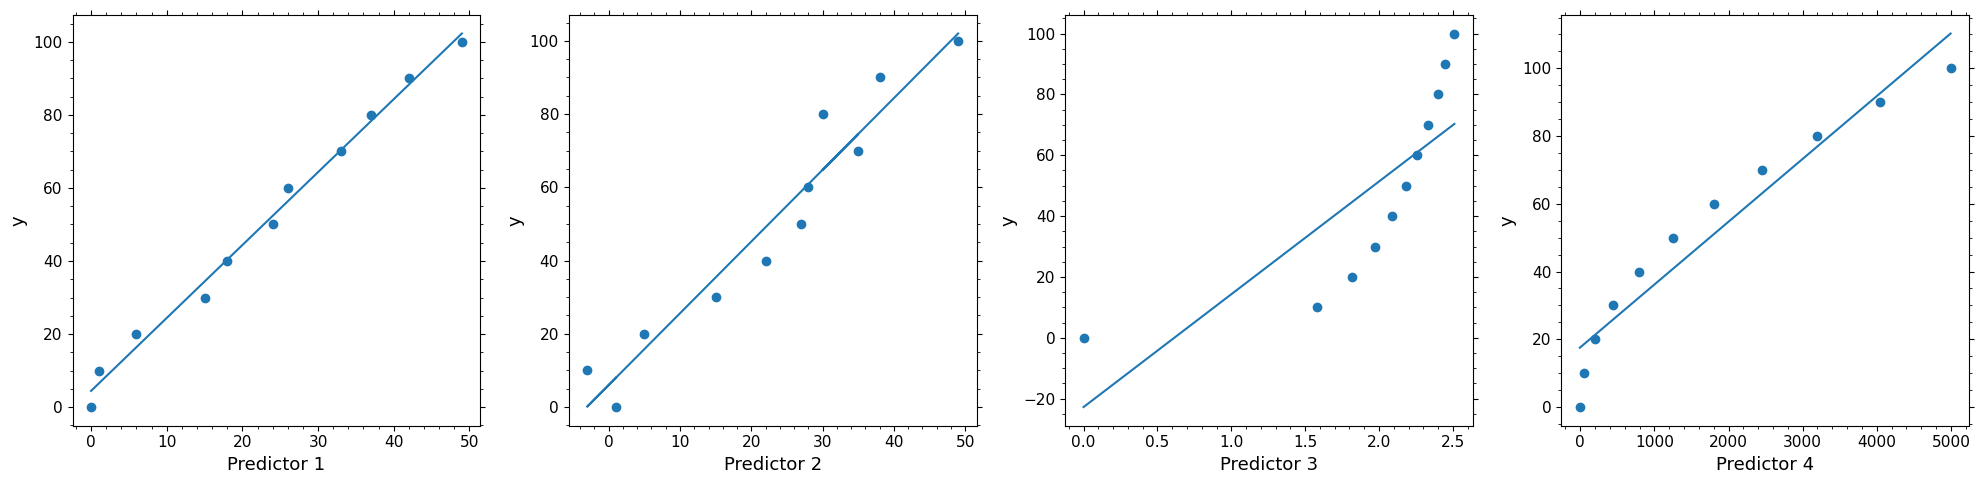

In [25]:
plt.figure(figsize=(20,5))
for p_idx in range(1,5):
    reg = GridSearchCV(LinearRegression(), param_grid={}, cv=5, scoring=make_scorer(r2_score))
    reg.fit(regression_df[["pred"+str(p_idx)]], regression_df["y"])
    reg_r2 = r2_score(regression_df["y"], reg.best_estimator_.predict(regression_df[["pred"+str(p_idx)]]))
    print("Predictor {}: b0 = {:.2f}, b1 = {:.2f}, r2 = {:.5f}.".format(p_idx, reg.best_estimator_.intercept_, reg.best_estimator_.coef_[0], reg_r2))
    plt.subplot(1,4,p_idx)
    plt.plot(regression_df[["pred"+str(p_idx)]], reg.predict(regression_df[["pred"+str(p_idx)]]))
    plt.xlabel("Predictor "+str(p_idx))
    plt.ylabel("y")
    plt.scatter(regression_df["pred"+str(p_idx)], regression_df["y"])
plt.show()

It is clear that of the univariate regression models, the one using predictor 1 performs the best, explaining 99% of the variance in the data. A first-step for the the forward selection would be to select this model, and test three regression models with predictor pairs 1 and 2, 1 and 3, and 1 and 4.

The second model above also appears to perform relatively well with a high R2 value. Despite a similar R2 value for the last model, we can see from the graph that there is a clear relationship between the residuals and the predictor value, which indicates that a different, non-linear model would be appropriate. The same is true for the third model which also has a much worse R2 score.

### Question 4.iii.

Predictor 1: b0 = 4.18, b1 = 2.04, b2 = -0.00, r2 = 0.99144.
Predictor 2: b0 = 7.45, b1 = 1.66, b2 = 0.01, r2 = 0.93761.
Predictor 3: b0 = 0.72, b1 = -60.87, b2 = 39.15, r2 = 0.98568.
Predictor 4: b0 = 10.31, b1 = 0.03, b2 = -0.00, r2 = 0.97947.


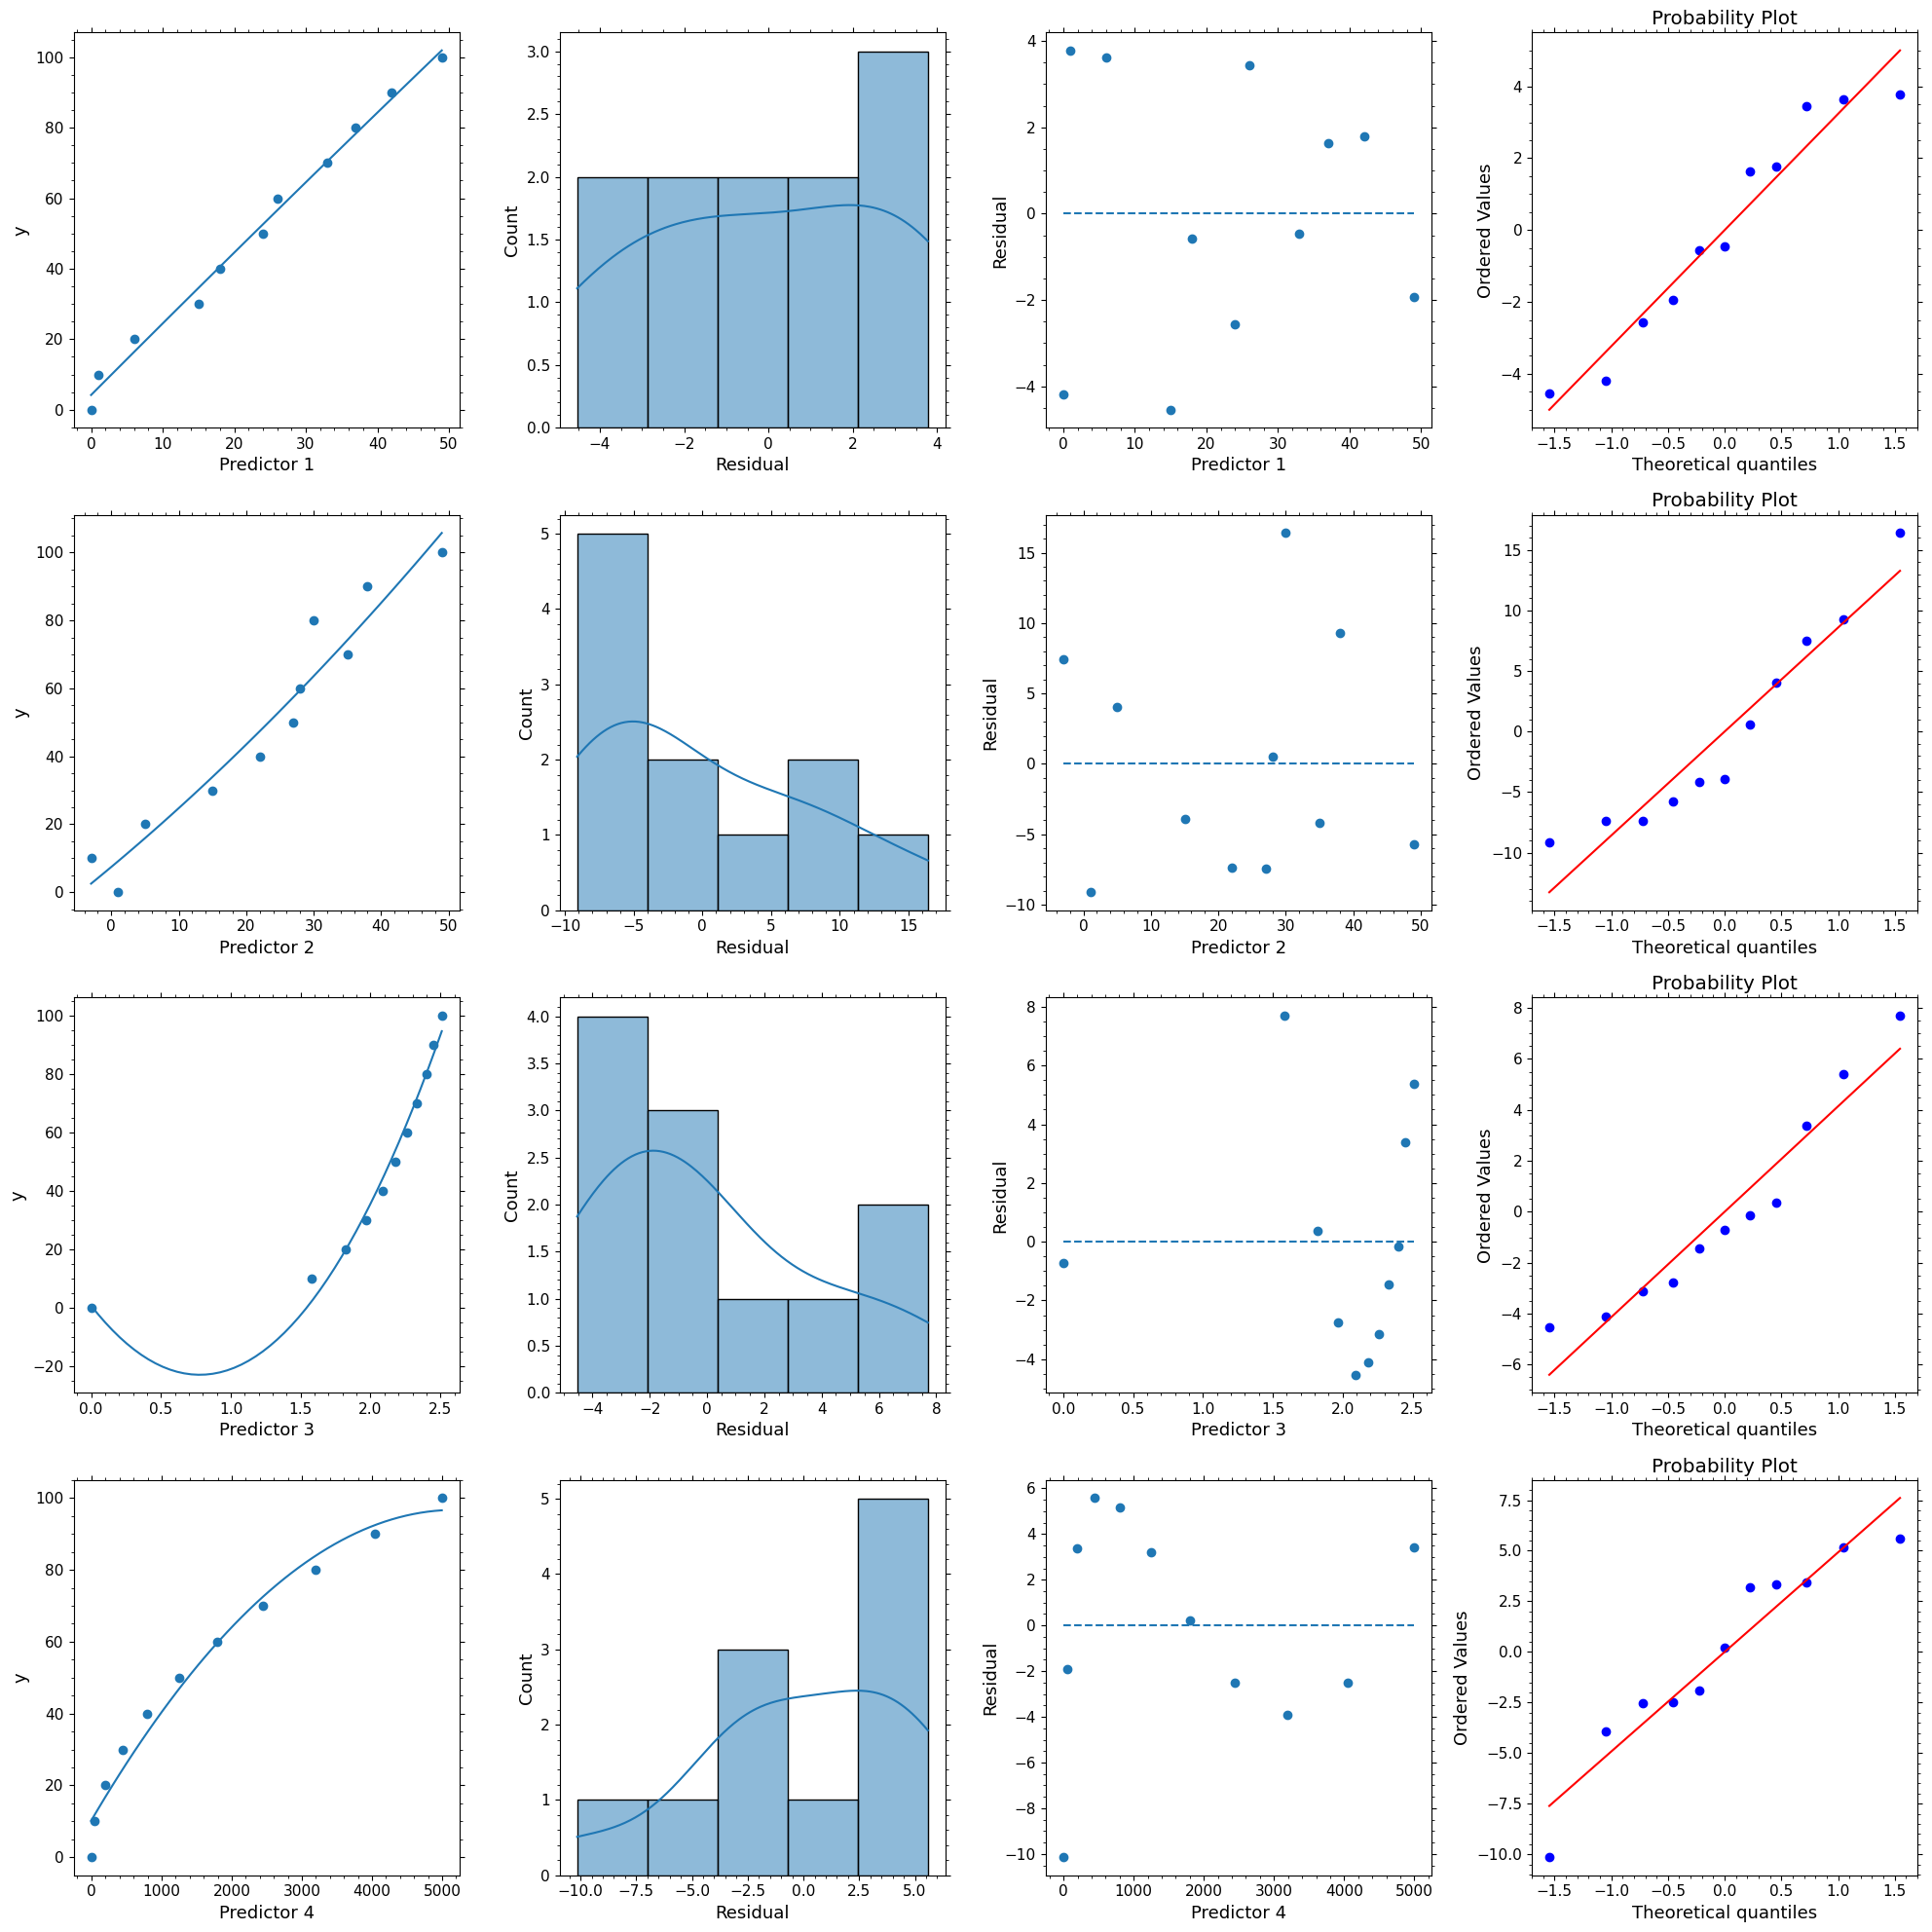

In [26]:
y = regression_df["y"]

plt.figure(figsize=(20,20))
for p_idx in range(1,5):
    regression_df["pred"+str(p_idx)+" ^2"] = regression_df["pred"+str(p_idx)]**2
    X = np.array(regression_df[["pred"+str(p_idx), "pred"+str(p_idx)+" ^2"]])
    reg = GridSearchCV(LinearRegression(), param_grid={}, cv=5, scoring="r2")
    reg.fit(X, y)
    reg_r2 = r2_score(y, reg.best_estimator_.predict(X))
    print("Predictor {}: b0 = {:.2f}, b1 = {:.2f}, b2 = {:.2f}, r2 = {:.5f}.".format(p_idx, reg.best_estimator_.intercept_,
                                                                                     reg.best_estimator_.coef_[0], reg.best_estimator_.coef_[1], reg_r2))
    
    plt.subplot(4,4,4*p_idx-3)
    x_plot = np.linspace(regression_df[["pred"+str(p_idx)]].min(), regression_df[["pred"+str(p_idx)]].max())
    model = reg.best_estimator_.predict
    plt.plot(x_plot, model(np.concatenate([x_plot, x_plot**2], axis=1)))
    plt.xlabel("Predictor "+str(p_idx))
    plt.ylabel("y")
    plt.scatter(X[:,0], y)

    residuals = y - model(X)
    plt.subplot(4,4,4*p_idx-2)
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residual")

    plt.subplot(4,4,4*p_idx-1)
    plt.scatter(X[:,0], residuals)
    plt.hlines(0, x_plot[0], x_plot[-1], linestyles="--")
    plt.xlabel("Predictor "+str(p_idx))
    plt.ylabel("Residual")

    plt.subplot(4,4,4*p_idx)
    sp.stats.probplot(residuals, plot=plt)


plt.show()

I created a quadratic regression model for this part, since this is one of the simplest models that can capture the monotonic non-linear relationship present in the 3rd and 4th predictors.

In the cases of these two predictors specifically, the model seems to conform to assumptions of homoskedastic and normally distributed residuals, although it is difficult to tell for sure with such a small sample size. However in both cases, we can still see a clear relationship between the predictor value and the residual, which may imply a more complex model is appropriate.

### Question 4.iv.

In [27]:
reg_mse = GridSearchCV(LinearRegression(), param_grid={}, cv=5, scoring=make_scorer(mean_squared_error))
reg_mse.fit(regression_df[["pred2"]], y)
reg_mse_r2 = r2_score(y, reg_mse.best_estimator_.predict(regression_df[["pred2"]]))
print("MSE Optimisation: b0 = {:.8f}, b1 = {:.8f}, r2 = {:.8f}.".format(reg_mse.best_estimator_.intercept_,
                                                                                     reg_mse.best_estimator_.coef_[0],
                                                                                     reg_mse_r2))

reg_mae = GridSearchCV(SGDRegressor(loss="epsilon_insensitive", epsilon=0), param_grid={}, cv=5, scoring=make_scorer(mean_squared_error))
reg_mae.fit(regression_df[["pred2"]], y)
reg_mae_r2 = r2_score(y, reg_mae.best_estimator_.predict(regression_df[["pred2"]]))
print("MAE Optimisation: b0 = {:.8f}, b1 = {:.8f}, r2 = {:.8f}.".format(reg_mae.best_estimator_.intercept_[0],
                                                                                     reg_mae.best_estimator_.coef_[0],
                                                                                     reg_mae_r2))

reg_huber = GridSearchCV(HuberRegressor(), param_grid={}, cv=5, scoring=make_scorer(mean_squared_error))
reg_huber.fit(regression_df[["pred2"]], y)
reg_huber_r2 = r2_score(y, reg_huber.best_estimator_.predict(regression_df[["pred2"]]))
print("Huber Optimisation: b0 = {:.8f}, b1 = {:.8f}, r2 = {:.8f}.".format(reg_huber.best_estimator_.intercept_,
                                                                                     reg_huber.best_estimator_.coef_[0],
                                                                                     reg_huber_r2))

MSE Optimisation: b0 = 6.02448454, b1 = 1.95842377, r2 = 0.93470225.
MAE Optimisation: b0 = 0.09475814, b1 = 1.99261603, r2 = 0.90777156.
Huber Optimisation: b0 = 5.41312550, b1 = 1.94047898, r2 = 0.93359497.


### Question 4.v.

This question concerns the bias-variance decomposition of MSE, in which we assume that the data is produced from some model $Y=f(x)+\epsilon$, where $Y$ and $\epsilon$ are random variables, $\epsilon$ is $N(0,\sigma _{e})$ distributed, and $f$ is a fixed, underlying function. Then we produce some model $\hat{f}$ to approximate $f$, where $\hat{f}(x)$ is a random variable for any $x$ which is different with each training run. The decomposition is then:

$$ E[(Y - \hat(f))^2] = E[f(x) - E[\hat{f}(x)]]^2 + E[(\hat{f}(x) - E[\hat{f}(x)])^2] + E[(Y-f(x))^2] $$

$$ MSE(\hat{f}) = Bias(\hat{f})^2 + Var(\hat{f}) + \sigma _{e}^2 $$

We will take predictor 2 as our $x$ in this case, and since we don't have access to the true $f$ underlying the data, we approximate this with the best performing OLS estimator, and then compute the bias-variance decomposition for the MAE optimised regression (our $\hat{f}$ in this case).

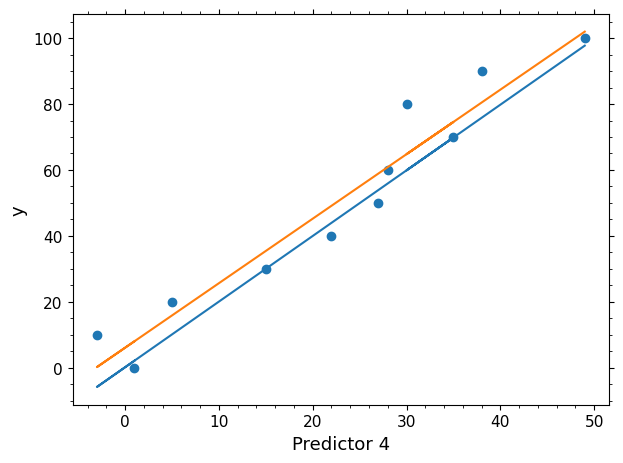

In [28]:
plt.plot(regression_df[["pred2"]], reg_mae.best_estimator_.predict(regression_df[["pred2"]]))
plt.plot(regression_df[["pred2"]], reg_mse.best_estimator_.predict(regression_df[["pred2"]]))
plt.xlabel("Predictor "+str(p_idx))
plt.ylabel("y")
plt.scatter(regression_df[["pred2"]], y)

In [29]:
y_pred_mse = reg_mse.best_estimator_.predict(regression_df[["pred2"]])
y_pred_mse

mae_cv = cross_validate(SGDRegressor(loss="epsilon_insensitive", epsilon=0, random_state=42), regression_df[["pred2"]], y, cv=5, scoring=make_scorer(mean_squared_error), return_estimator=True)
mae_estimators = mae_cv["estimator"]
mae_test_scores = mae_cv["test_score"]

In [30]:
y_pred_mae_cv = np.hstack([mae_estimators[run_idx].predict(regression_df[["pred2"]]).reshape(11, -1) for run_idx in range(5)])
print("Square of the bias: ", (y_pred_mae_cv - y_pred_mse.reshape(11,1)).mean()**2)
print("Variance of the estimator: ", y_pred_mae_cv.var(axis=1).mean())
print("Irreducible error: ", ((y - y_pred_mse)**2).mean())
print("MSE of estimator: ", ((y - y_pred_mae_cv.mean(axis=1))**2).mean())
print("Sum of decomposition: ", (y_pred_mae_cv - y_pred_mse.reshape(11,1)).mean()**2 + y_pred_mae_cv.var(axis=1).mean() + ((y - y_pred_mse)**2).mean())

Square of the bias:  14.835542632139573
Variance of the estimator:  6.572889563278667
Irreducible error:  65.2977482365708
MSE of estimator:  82.20967038459179
Sum of decomposition:  86.70618043198904


The MSE is not exactly equal to the sum of the three components since we are only computing estimates of the bias and variance of the estimator, in particular over only 5 training runs. 

### Question 4.vi.

The given multiple linear model performs quite well since it explains over 99% of the variance in the data. However, it seems that predictor 2 should be removed from the model, since the p-value for its inclusion is very high at 0.69. After its removal it is likely that predictor 4 will still have a high p-value and will also be removed. Predictor 3 also has "marginal significance" at just below 0.1 for its p-value, so further investigation is required to figure out whether its inclusion is appropriate in the model.

### Question 4.vii

In [31]:
for p_idx in range(1,5):
    print(OLS(y, regression_df[["pred"+str(p_idx)]]).fit().summary())
print(OLS(y, regression_df[["pred1", "pred3"]]).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2336.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):                    3.47e-13
Time:                        16:20:25   Log-Likelihood:                         -30.472
No. Observations:                  11   AIC:                                      62.94
Df Residuals:                      10   BIC:                                      63.34
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/hom

### Question 4.viii.

In [32]:
print(OLS(y, regression_df[["pred1", "pred2", "pred3", "pred4"]]).fit().summary())
print(OLS(y, regression_df[["pred1", "pred3", "pred4"]]).fit().summary())
print(OLS(y, regression_df[["pred1", "pred3"]]).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              1622.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):                    1.85e-10
Time:                        16:20:25   Log-Likelihood:                         -22.909
No. Observations:                  11   AIC:                                      53.82
Df Residuals:                       7   BIC:                                      55.41
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              2395.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):                    3.76e-12
Time:                        16:20:25   Log-Likelihood:                         -23.082
No. Observations:                  11   AIC:                                      52.16
Df Residuals:                       8   BIC:                                      53.36
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

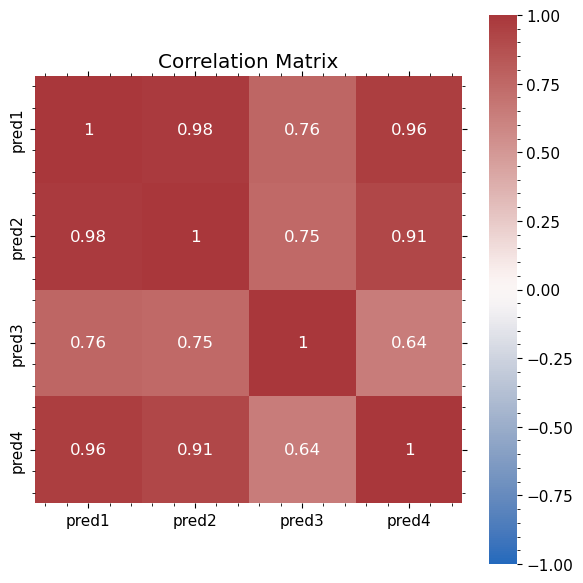

In [33]:
corr = regression_df.iloc[:, 1:5].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cbar=True, cmap="vlag", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

### Question 4.ix.

As we can see, even though the model selection ultimately led us to include predictors 1 and 3 together, they are highly correlated with a Pearson coefficient of 0.76. Therefore it may be more appropriate to prefer the simple model using just predictor 1, since this is not only simpler but it also still explains 96% of the variance within the data.

### Question 4.x.

In [34]:
regression_df["pred5"] = [0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]

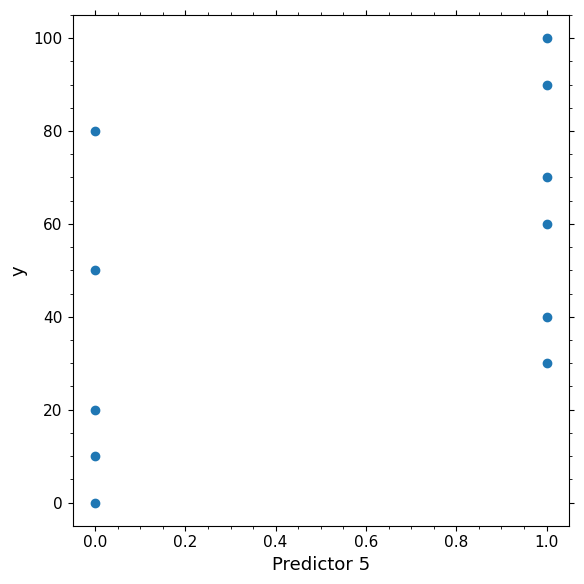

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(regression_df["pred5"], regression_df["y"])
plt.xlabel("Predictor 5")
plt.ylabel("y")
plt.show()

Predictor 5: b0 = 32.00, b1 = 33.00, r2 = 0.27000.


/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


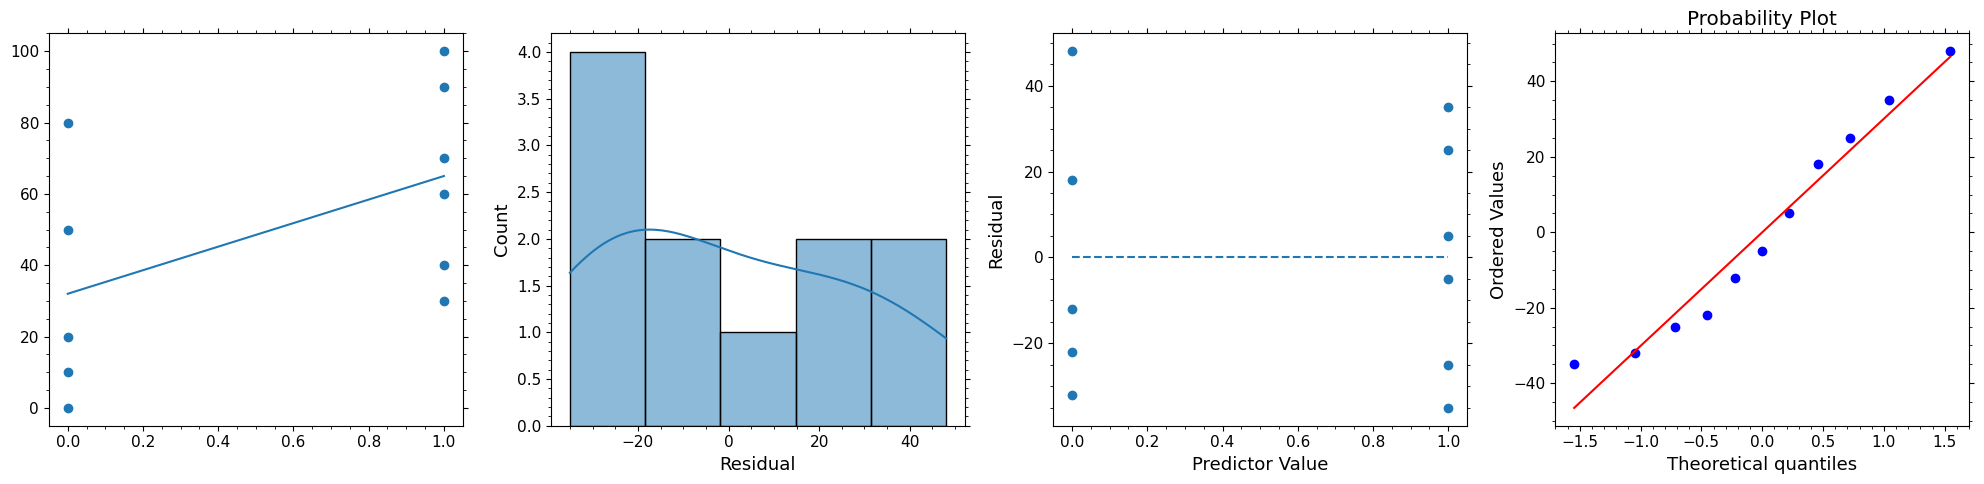

In [36]:
X_5 = regression_df[["pred5"]]

reg_5 = GridSearchCV(LinearRegression(), param_grid={}, cv=5, scoring=make_scorer(r2_score))
reg_5.fit(X_5, regression_df["y"])
reg_5_r2 = r2_score(regression_df["y"], reg_5.best_estimator_.predict(X_5))
print("Predictor 5: b0 = {:.2f}, b1 = {:.2f}, r2 = {:.5f}.".format(reg_5.best_estimator_.intercept_, reg_5.best_estimator_.coef_[0], reg_5_r2))

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
x_plot = np.linspace(X_5.min(), X_5.max())
model_5 = reg_5.best_estimator_.predict
plt.plot(x_plot, model_5(x_plot))
plt.scatter(X_5, y)

residuals_5 = y - model_5(X_5)
plt.subplot(1,4,2)
sns.histplot(residuals_5, kde=True)
plt.xlabel("Residual")

plt.subplot(1,4,3)
plt.scatter(X_5, residuals_5)
plt.hlines(0, x_plot[0], x_plot[-1], linestyles="--")
plt.xlabel("Predictor Value")
plt.ylabel("Residual")

plt.subplot(1,4,4)
sp.stats.probplot(residuals_5, plot=plt)

plt.show()

There does appear to be a weak linear relationship between predictor 5 and the target variable. The regression model performs fairly well, given that the residuals appear to be homoskedastic and normally distributed.

Predictor 5: b0 = {:.2f}, coefs =  [ 1.56474691e+00 -8.64772077e-02  5.51533531e+00  3.44593085e-03
 -6.14506126e-01] , r2 = -0.27001.


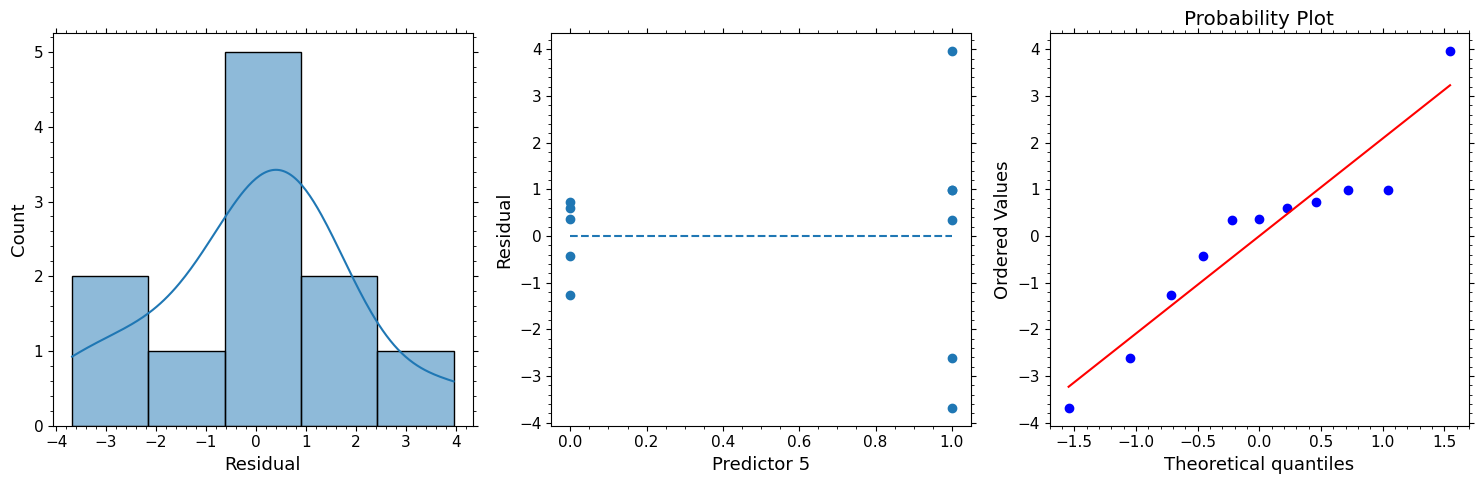

In [37]:
X_5_full = regression_df[["pred1", "pred2", "pred3", "pred4", "pred5"]]

reg_5_full = GridSearchCV(LinearRegression(), param_grid={}, cv=5, scoring=make_scorer(r2_score))
reg_5_full.fit(X_5_full, y)
reg_5_full_r2 = r2_score(y, reg_5_full.best_estimator_.predict(X_5_full))
print("Predictor 5: b0 = {:.2f}, coefs = ", reg_5_full.best_estimator_.coef_, ", r2 = {:.5f}.".format(reg_5_full.best_estimator_.intercept_, reg_5_full_r2))
model_5_full = reg_5_full.best_estimator_.predict

plt.figure(figsize=(15,5))

residuals_5_full = y - model_5_full(X_5_full)
plt.subplot(1,3,1)
sns.histplot(residuals_5_full, kde=True)
plt.xlabel("Residual")

plt.subplot(1,3,2)
plt.scatter([X_5_full["pred5"]], residuals_5_full)
plt.hlines(0, x_plot[0], x_plot[-1], linestyles="--")
plt.xlabel("Predictor 5")
plt.ylabel("Residual")

plt.subplot(1,3,3)
sp.stats.probplot(residuals_5_full, plot=plt)

plt.show()


In the full model, the residuals seem normally distributed but violate the homoskedasticity assumption with respect to predictor 5, with much more variance in the case that this predictor takes the value of 1.

In [38]:
print(OLS(y, X_5_full).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              1126.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):                    7.91e-09
Time:                        16:20:32   Log-Likelihood:                         -22.844
No. Observations:                  11   AIC:                                      55.69
Df Residuals:                       6   BIC:                                      57.68
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Question 4.xi.

In [39]:
regression_df["pred6"] = [2, 0, 0, 0, 2, 1, 3, 1, 3, 1, 1]

In [40]:
regression_df = pd.concat([regression_df, pd.get_dummies(regression_df["pred6"], prefix="pred6")], axis=1)
regression_df

,y,pred1,pred2,pred3,pred4,pred1 ^2,pred2 ^2,pred3 ^2,pred4 ^2,pred5,pred6,pred6_0,pred6_1,pred6_2,pred6_3
0,0,0,1,0.00,-5,0,1,0.0000,25,0,2,0,0,1,0
1,10,1,-3,1.58,48,1,9,2.4964,2304,0,0,1,0,0,0
2,20,6,5,1.82,194,36,25,3.3124,37636,0,0,1,0,0,0
3,30,15,15,1.97,443,225,225,3.8809,196249,1,0,1,0,0,0
4,40,18,22,2.09,798,324,484,4.3681,636804,1,2,0,0,1,0
5,50,24,27,2.18,1246,576,729,4.7524,1552516,0,1,0,1,0,0
6,60,26,28,2.26,1799,676,784,5.1076,3236401,1,3,0,0,0,1
7,70,33,35,2.33,2446,1089,1225,5.4289,5982916,1,1,0,1,0,0
8,80,37,30,2.40,3196,1369,900,5.7600,10214416,0,3,0,0,0,1
9,90,42,38,2.45,4048,1764,1444,6.0025,16386304,1,1,0,1,0,0


Predictor 6: b0 = {:.2f}, coefs =  [-26.875  30.625 -26.875  23.125] , r2 = 46.87500.


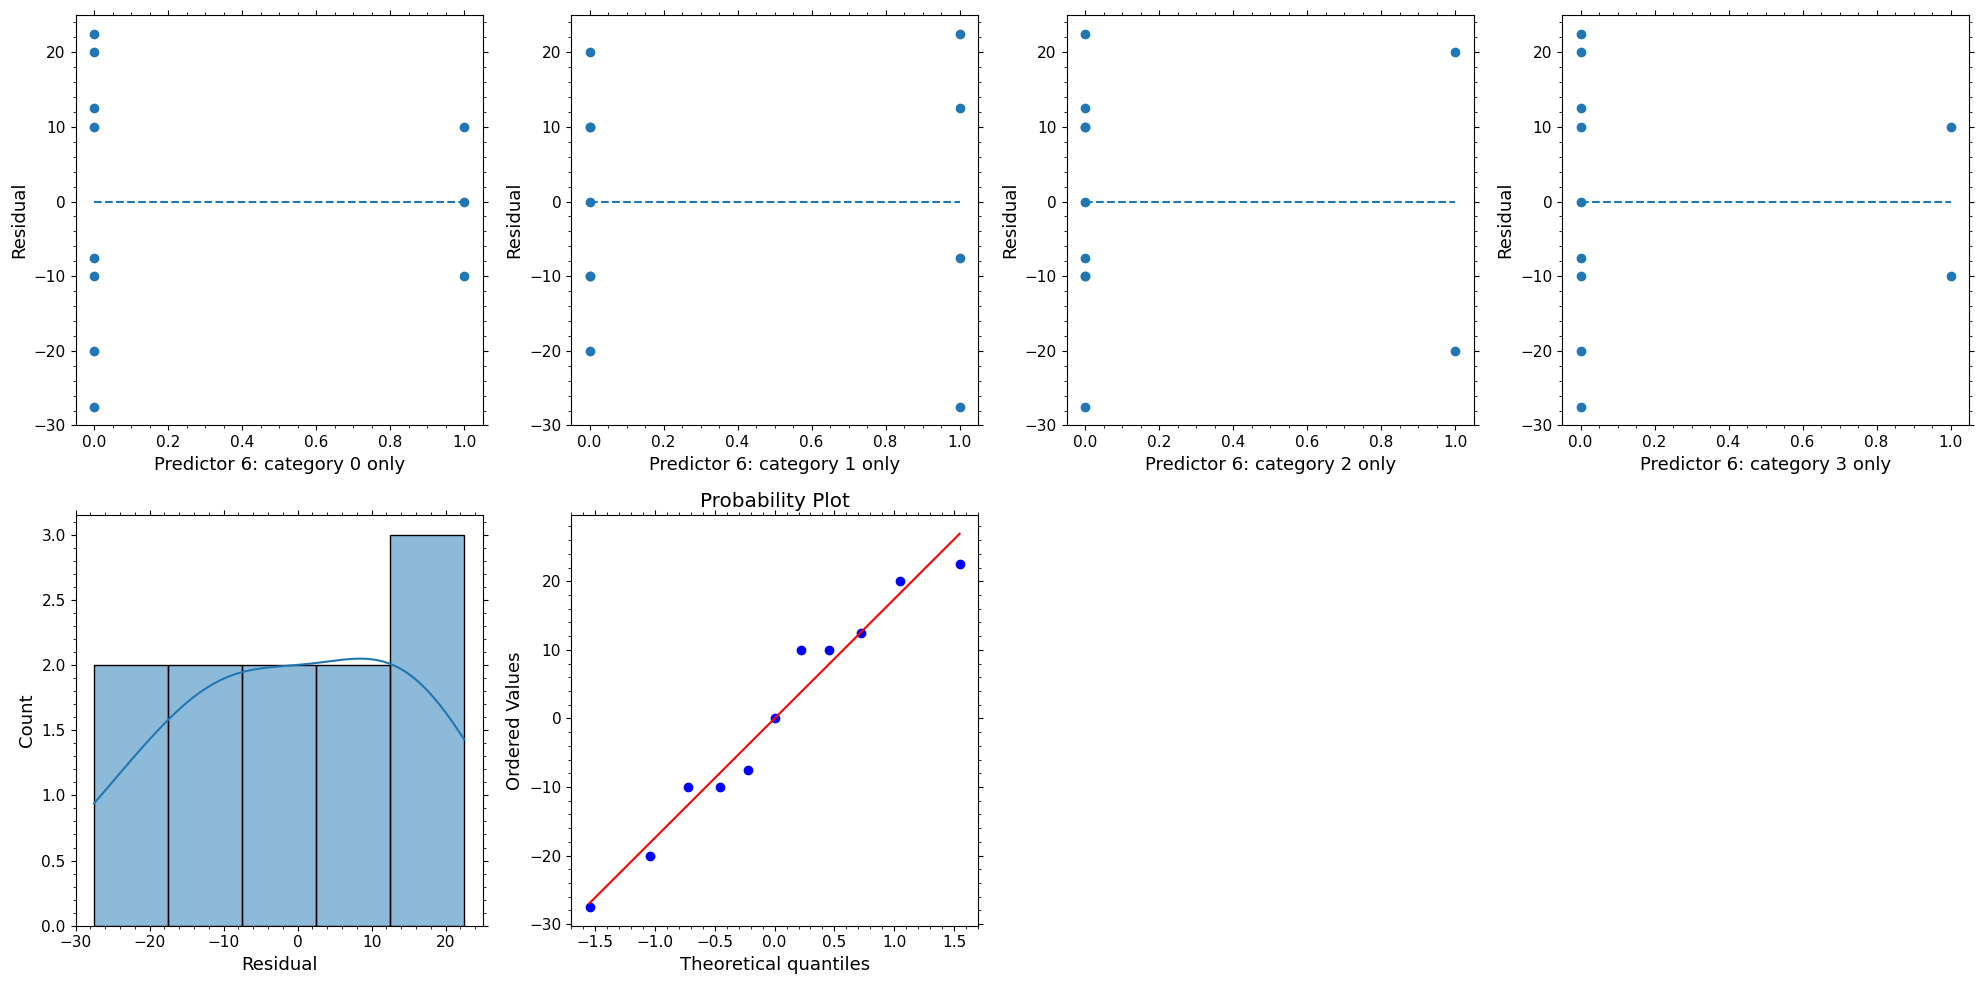

In [41]:
X_6 = regression_df[["pred6_0", "pred6_1", "pred6_2", "pred6_3"]]

reg_6 = GridSearchCV(LinearRegression(), param_grid={}, cv=5, scoring=make_scorer(r2_score))
reg_6.fit(X_6, y)
reg_6_r2 = r2_score(y, reg_6.best_estimator_.predict(X_6))
print("Predictor 6: b0 = {:.2f}, coefs = ", reg_6.best_estimator_.coef_, ", r2 = {:.5f}.".format(reg_6.best_estimator_.intercept_, reg_6_r2))

plt.figure(figsize=(20,10))


model_6 = reg_6.best_estimator_.predict
residuals_6 = y - model_6(X_6)

for pred6_cat in range(4): 
    plt.subplot(2,4,pred6_cat+1)   
    plt.scatter(X_6["pred6_"+str(pred6_cat)], residuals_6)
    plt.hlines(0, 0, 1, linestyles="--")
    plt.xlabel("Predictor 6: category {} only".format(pred6_cat))
    plt.ylabel("Residual")

plt.subplot(2,4,5)
sns.histplot(residuals_6, kde=True)
plt.xlabel("Residual")

plt.subplot(2,4,6)
sp.stats.probplot(residuals_6, plot=plt)

plt.show()

The model in this case also performs well, with homoskedastic residuals with respect to predictor 6, and the fact that they are apparently normally distributed - although the histogram does seem to show a slightly platykurtic distribution.

Predictor 6: b0 = {:.2f}, coefs =  [ 1.17924526e+00 -2.65858787e-01  8.71775081e+00  5.79623226e-03
  1.76922459e+00 -5.59272425e+00  2.41774684e+00 -7.82169573e-01
  3.95714699e+00] , r2 = 0.93347.


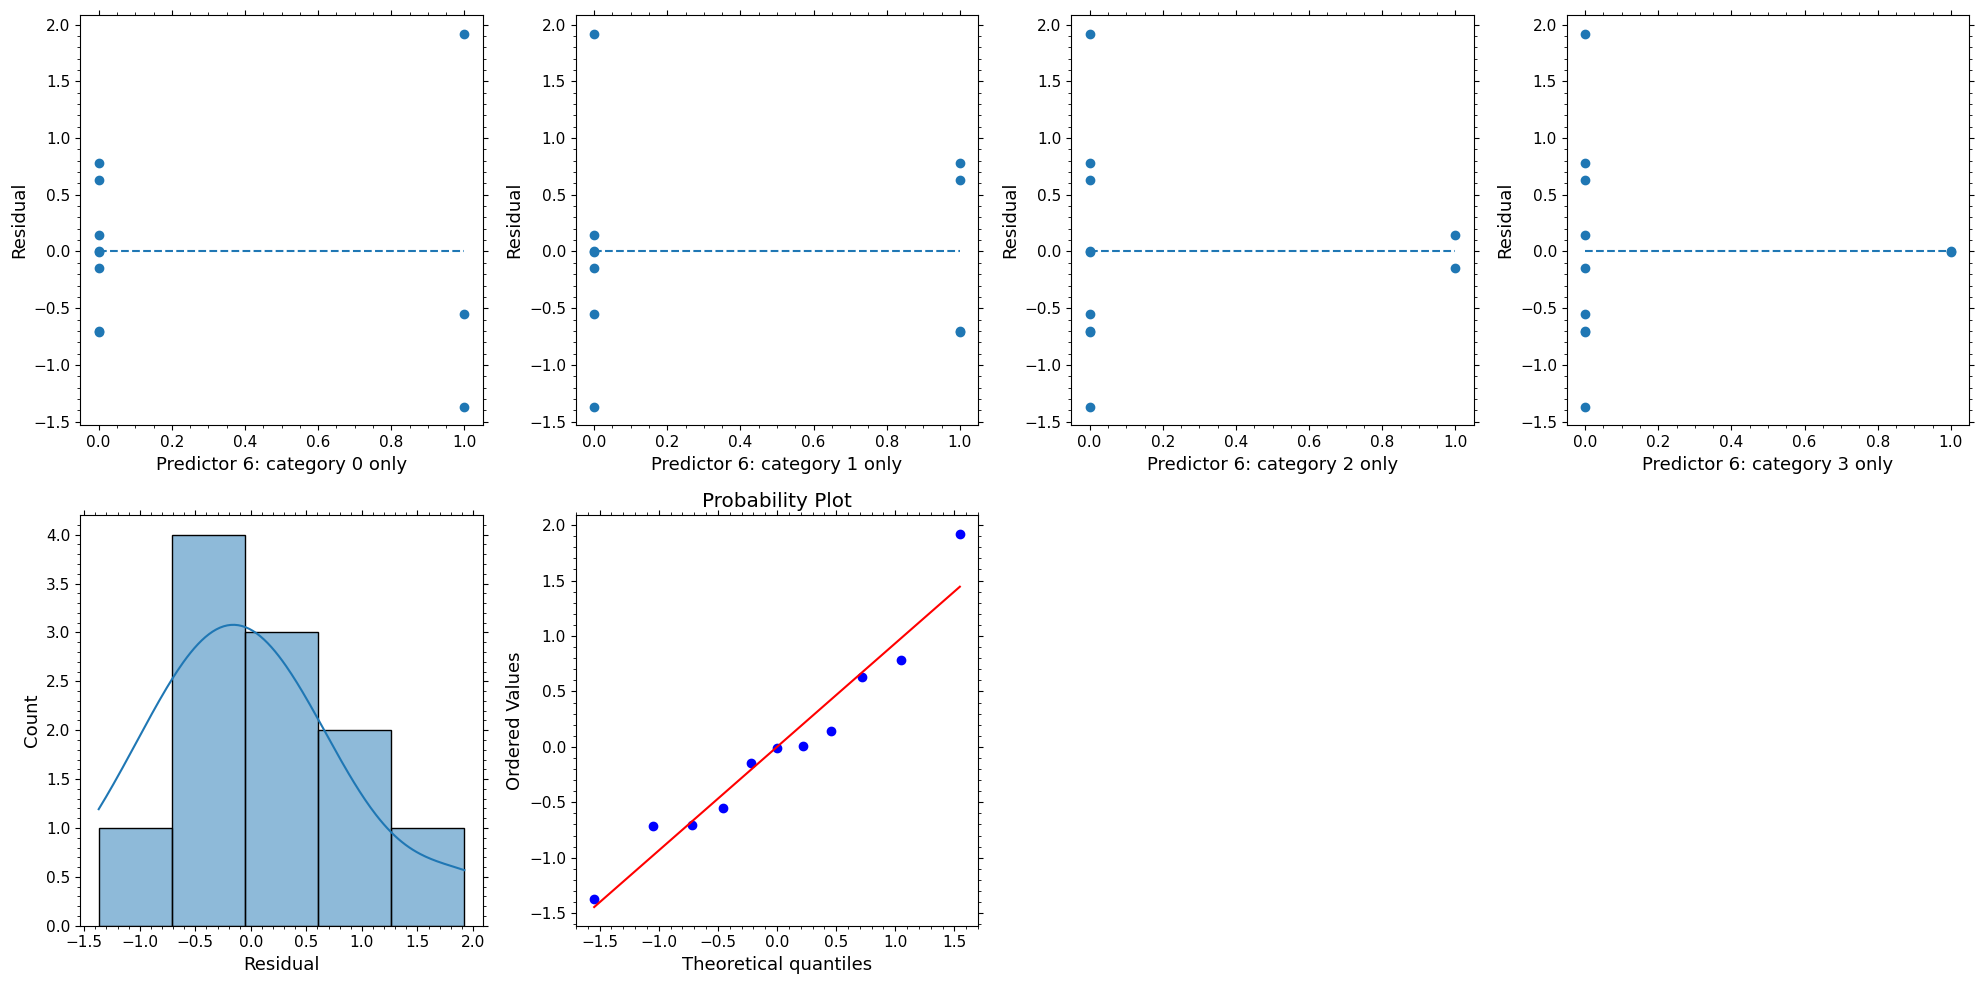

In [42]:
X_6_full = regression_df[["pred1", "pred2", "pred3", "pred4", "pred5", "pred6_0", "pred6_1", "pred6_2", "pred6_3"]]

reg_6_full = GridSearchCV(LinearRegression(), param_grid={}, cv=5, scoring=make_scorer(r2_score))
reg_6_full.fit(X_6_full, y)
reg_6_full_r2 = r2_score(y, reg_6_full.best_estimator_.predict(X_6_full))
print("Predictor 6: b0 = {:.2f}, coefs = ", reg_6_full.best_estimator_.coef_, ", r2 = {:.5f}.".format(reg_6_full.best_estimator_.intercept_, reg_6_full_r2))
model_6_full = reg_6_full.best_estimator_.predict

plt.figure(figsize=(20,10))

residuals_6_full = y - model_6_full(X_6_full)

for pred6_cat in range(4): 
    plt.subplot(2,4,pred6_cat+1)   
    plt.scatter(X_6_full["pred6_"+str(pred6_cat)], residuals_6_full)
    plt.hlines(0, 0, 1, linestyles="--")
    plt.xlabel("Predictor 6: category {} only".format(pred6_cat))
    plt.ylabel("Residual")

plt.subplot(2,4,5)
sns.histplot(residuals_6_full, kde=True)
plt.xlabel("Residual")

plt.subplot(2,4,6)
sp.stats.probplot(residuals_6_full, plot=plt)

plt.show()

In the full model, the normal distribution of the residuals is much more apparent, although there is some heteroskedasticity of the residuals with respect to the 0th category of predictor 6.

In [43]:
print(OLS(y, X_6_full).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     346.9
Date:                Sun, 29 Oct 2023   Prob (F-statistic):            0.00288
Time:                        16:20:38   Log-Likelihood:                -13.803
No. Observations:                  11   AIC:                             45.61
Df Residuals:                       2   BIC:                             49.19
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pred1          1.1792      0.511      2.309      0.1

/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


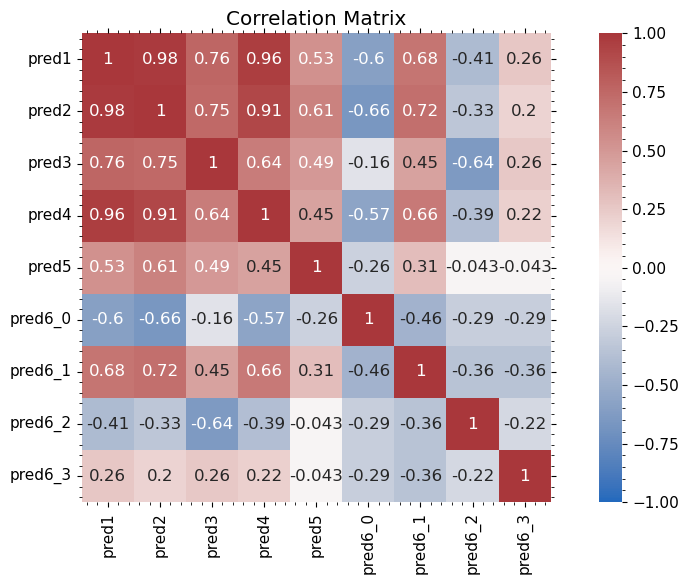

In [44]:
plt.figure(figsize=(10,6))
sns.heatmap(X_6_full.corr(), annot=True, square=True, cbar=True, cmap="vlag", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [45]:
print(OLS(y, X_6_full).fit().summary())
print(OLS(y, X_6_full.drop(columns=["pred6_2"])).fit().summary())
print(OLS(y, X_6_full.drop(columns=["pred6_2", "pred2"])).fit().summary())
print(OLS(y, X_6_full.drop(columns=["pred6_2", "pred2", "pred5"])).fit().summary())
print(OLS(y, X_6_full.drop(columns=["pred6_2", "pred2", "pred5", "pred6_1"])).fit().summary())
print(OLS(y, X_6_full.drop(columns=["pred6_2", "pred2", "pred5", "pred6_1", "pred6_0"])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     346.9
Date:                Sun, 29 Oct 2023   Prob (F-statistic):            0.00288
Time:                        16:20:40   Log-Likelihood:                -13.803
No. Observations:                  11   AIC:                             45.61
Df Residuals:                       2   BIC:                             49.19
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pred1          1.1792      0.511      2.309      0.1

/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/hom